In [ ]:
!uv add pyplot
!uv add scipy
!uv add scikit-learn
!uv add pandas
!uv add json
!uv add numpy
!uv add openai
!uv add tqdm
!uv add matplotlib

In [23]:
import pandas as pd
import json
import numpy as np
from openai import OpenAI
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# 1. 데이터 로드 및 전처리
print("데이터셋 로딩 중...")
ds = load_dataset("birdsql/bird_sql_dev_20251106")
df = ds['dev_20251106'].to_pandas()
hard_df = df[df['difficulty'] == 'challenging'].copy()
print(f"로드 완료. 'challenging' 난이도 데이터 {len(hard_df)}개.")

# 2. 훈련/테스트 데이터 분리
print("데이터를 훈련셋과 테스트셋으로 분리 중...")
train_df, test_df = train_test_split(hard_df, test_size=0.2, random_state=42)
print(f"훈련셋: {len(train_df)}개, 테스트셋: {len(test_df)}개")

# 3. OpenAI 클라이언트 설정
print("OpenAI 클라이언트 설정 중...")
MODEL_NAME="Qwen/Qwen3-Next-80B-A3B-Instruct"
MODEL_BASE_URI="http://211.47.56.81:7972/v1"
MODEL_API_KEY="token-abc123"
client = OpenAI(api_key=MODEL_API_KEY, base_url=MODEL_BASE_URI)
print("설정 완료.")


데이터셋 로딩 중...
로드 완료. 'challenging' 난이도 데이터 231개.
데이터를 훈련셋과 테스트셋으로 분리 중...
훈련셋: 184개, 테스트셋: 47개
OpenAI 클라이언트 설정 중...
설정 완료.


In [24]:
client.chat.completions.create(
    model=MODEL_NAME,
    messages=[{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "What is the capital of the moon?"}]
)


ChatCompletion(id='chatcmpl-e84890f13e5049d1b162e589671f6e0e', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The Moon does not have a capital city — in fact, it has no government, no permanent human population, and no cities at all.\n\nWhile humans have landed on the Moon (most famously during NASA’s Apollo missions between 1969 and 1972), and there are plans for future lunar bases, no country or organization has established a sovereign presence or administrative capital on the Moon. Under the 1967 Outer Space Treaty, no nation can claim sovereignty over the Moon or any other celestial body.\n\nSo, just like there’s no capital of Mars or Venus, there’s no capital of the Moon — it’s a natural satellite, not a country or political entity. 🌕', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763536616, model='Qwen/Qwen

In [25]:
# 4. 강화학습을 위한 프롬프트 정의


schema_info = """
Schema for frpm:
(0, 'CDSCode', 'TEXT', 1, None, 1)
(1, 'Academic Year', 'TEXT', 0, None, 0)
(2, 'County Code', 'TEXT', 0, None, 0)
(3, 'District Code', 'INTEGER', 0, None, 0)
(4, 'School Code', 'TEXT', 0, None, 0)
(5, 'County Name', 'TEXT', 0, None, 0)
(6, 'District Name', 'TEXT', 0, None, 0)
(7, 'School Name', 'TEXT', 0, None, 0)
(8, 'District Type', 'TEXT', 0, None, 0)
(9, 'School Type', 'TEXT', 0, None, 0)
(10, 'Educational Option Type', 'TEXT', 0, None, 0)
(11, 'NSLP Provision Status', 'TEXT', 0, None, 0)
(12, 'Charter School (Y/N)', 'INTEGER', 0, None, 0)
(13, 'Charter School Number', 'TEXT', 0, None, 0)
(14, 'Charter Funding Type', 'TEXT', 0, None, 0)
(15, 'IRC', 'INTEGER', 0, None, 0)
(16, 'Low Grade', 'TEXT', 0, None, 0)
(17, 'High Grade', 'TEXT', 0, None, 0)
(18, 'Enrollment (K-12)', 'REAL', 0, None, 0)
(19, 'Free Meal Count (K-12)', 'REAL', 0, None, 0)
(20, 'Percent (%) Eligible Free (K-12)', 'REAL', 0, None, 0)
(21, 'FRPM Count (K-12)', 'REAL', 0, None, 0)
(22, 'Percent (%) Eligible FRPM (K-12)', 'REAL', 0, None, 0)
(23, 'Enrollment (Ages 5-17)', 'REAL', 0, None, 0)
(24, 'Free Meal Count (Ages 5-17)', 'REAL', 0, None, 0)
(25, 'Percent (%) Eligible Free (Ages 5-17)', 'REAL', 0, None, 0)
(26, 'FRPM Count (Ages 5-17)', 'REAL', 0, None, 0)
(27, 'Percent (%) Eligible FRPM (Ages 5-17)', 'REAL', 0, None, 0)
(28, '2013-14 CALPADS Fall 1 Certification Status', 'INTEGER', 0, None, 0)

Schema for satscores:
(0, 'cds', 'TEXT', 1, None, 1)
(1, 'rtype', 'TEXT', 1, None, 0)
(2, 'sname', 'TEXT', 0, None, 0)
(3, 'dname', 'TEXT', 0, None, 0)
(4, 'cname', 'TEXT', 0, None, 0)
(5, 'enroll12', 'INTEGER', 1, None, 0)
(6, 'NumTstTakr', 'INTEGER', 1, None, 0)
(7, 'AvgScrRead', 'INTEGER', 0, None, 0)
(8, 'AvgScrMath', 'INTEGER', 0, None, 0)
(9, 'AvgScrWrite', 'INTEGER', 0, None, 0)
(10, 'NumGE1500', 'INTEGER', 0, None, 0)

Schema for schools:
(0, 'CDSCode', 'TEXT', 1, None, 1)
(1, 'NCESDist', 'TEXT', 0, None, 0)
(2, 'NCESSchool', 'TEXT', 0, None, 0)
(3, 'StatusType', 'TEXT', 1, None, 0)
(4, 'County', 'TEXT', 1, None, 0)
(5, 'District', 'TEXT', 1, None, 0)
(6, 'School', 'TEXT', 0, None, 0)
(7, 'Street', 'TEXT', 0, None, 0)
(8, 'StreetAbr', 'TEXT', 0, None, 0)
(9, 'City', 'TEXT', 0, None, 0)
(10, 'Zip', 'TEXT', 0, None, 0)
(11, 'State', 'TEXT', 0, None, 0)
(12, 'MailStreet', 'TEXT', 0, None, 0)
(13, 'MailStrAbr', 'TEXT', 0, None, 0)
(14, 'MailCity', 'TEXT', 0, None, 0)
(15, 'MailZip', 'TEXT', 0, None, 0)
(16, 'MailState', 'TEXT', 0, None, 0)
(17, 'Phone', 'TEXT', 0, None, 0)
(18, 'Ext', 'TEXT', 0, None, 0)
(19, 'Website', 'TEXT', 0, None, 0)
(20, 'OpenDate', 'DATE', 0, None, 0)
(21, 'ClosedDate', 'DATE', 0, None, 0)
(22, 'Charter', 'INTEGER', 0, None, 0)
(23, 'CharterNum', 'TEXT', 0, None, 0)
(24, 'FundingType', 'TEXT', 0, None, 0)
(25, 'DOC', 'TEXT', 1, None, 0)
(26, 'DOCType', 'TEXT', 1, None, 0)
(27, 'SOC', 'TEXT', 0, None, 0)
(28, 'SOCType', 'TEXT', 0, None, 0)
(29, 'EdOpsCode', 'TEXT', 0, None, 0)
(30, 'EdOpsName', 'TEXT', 0, None, 0)
(31, 'EILCode', 'TEXT', 0, None, 0)
(32, 'EILName', 'TEXT', 0, None, 0)
(33, 'GSoffered', 'TEXT', 0, None, 0)
(34, 'GSserved', 'TEXT', 0, None, 0)
(35, 'Virtual', 'TEXT', 0, None, 0)
(36, 'Magnet', 'INTEGER', 0, None, 0)
(37, 'Latitude', 'REAL', 0, None, 0)
(38, 'Longitude', 'REAL', 0, None, 0)
(39, 'AdmFName1', 'TEXT', 0, None, 0)
(40, 'AdmLName1', 'TEXT', 0, None, 0)
(41, 'AdmEmail1', 'TEXT', 0, None, 0)
(42, 'AdmFName2', 'TEXT', 0, None, 0)
(43, 'AdmLName2', 'TEXT', 0, None, 0)
(44, 'AdmEmail2', 'TEXT', 0, None, 0)
(45, 'AdmFName3', 'TEXT', 0, None, 0)
(46, 'AdmLName3', 'TEXT', 0, None, 0)
(47, 'AdmEmail3', 'TEXT', 0, None, 0)
(48, 'LastUpdate', 'DATE', 1, None, 0)
"""


# --- 초기 시스템 프롬프트 ---
SystemPrompt = f"""당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다.
{schema_info}를 참조해서 사용자의 질문을 데이터베이스 쿼리로 변환하는 것이 목표입니다.
"""


# --- 초기 시스템 프롬프트 ---
SystemPrompt = f"""당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다.
"""

# --- Reflexion(자기 성찰) 생성을 위한 프롬프트 ---
reflexion_prompt_template = """당신은 당신이 작성한 SQL 쿼리의 오류를 분석하고 수정하는 역할을 맡았습니다.

방금 당신이 작성한 쿼리는 실행 결과가 정답과 일치하지 않았습니다.

**상황 정보:**

1. **User Query:** {query}
2. **Generated SQL:** {previous_sql}
3. **Evaluator Feedback:** {feedback}

**지시:**
평가자의 피드백을 참고하여, 이전 SQL이 왜 틀렸는지 간결하게 원인을 분석하세요.
그리고 다음 시도에서 **어떻게 수정해야 정답을 맞출 수 있을지** 구체적인 수정 계획(Plan)을 한 문장으로 작성하세요.

**출력 형식:**
오직 수정 계획(Reflection)만 텍스트로 출력하세요.
"""

# --- 평가 및 보상 점수 생성을 위한 프롬프트 ---
evaluation_prompt_template = """당신은 SQL 쿼리 평가 전문가입니다. 당신의 임무는 생성된 SQL 쿼리의 실행 결과가 정답(Evidence)과 일치하는지 평가하고, 정량적인 보상 점수와 상세한 피드백을 제공하는 것입니다.

**평가 기준:**
- **+3점 (완벽히 정답):** 실행 결과가 정답(Evidence)과  SQL(정답) 모든 면에서(데이터, 순서, 형식) 완벽하게 일치합니다.
- **+1점 (정답):** 실행 결과가 정답(Evidence)과 모든 면에서 일치하지만, SQL(정답)과 출력 순서가 다르거나 사소한 형식 차이가 있습니다.
- **+0.7점 (의미상 정답):** 데이터는 정확하지만, Evidence와 출력 순서가 다르거나 사소한 형식 차이가 있습니다.
- **-0.5점 (실행은 되나 오답):** SQL 쿼리가 문법적으로는 맞아 실행되지만, 질문의 의도를 잘못 파악하여 틀린 결과를 반환합니다.
- **-1.0점 (실행 불가 또는 심각한 오류):** SQL 문법 오류가 있어 실행되지 않거나, 질문의 핵심 요구사항을 완전히 놓쳤습니다.

**평가 대상 정보:**
1. **User Query (사용자 질문):** {query}
2. **Evidence (정답 데이터):** {evidence}
3. **SQL (정답):** {sql}
4. **LLM Result (생성된 SQL 쿼리):** {llm_result}

**출력 형식:**
평가 결과를 다음 형식에 맞춰 **오직 JSON 객체 하나만** 출력해주세요. 당신의 의견이나 다른 설명은 절대 포함하지 마세요.
```json
{{
  "reward_score": "평가 기준에 따른 -1.0에서 +1.0 사이의 숫자 점수",
  "correctness": "'Correct', 'Partially Correct', 'Incorrect' 중 하나",
  "feedback": "점수를 매긴 이유와, 쿼리를 개선하기 위한 구체적이고 건설적인 피드백을 작성해주세요."
}}
```
"""

batch_prompt_updater_template = """당신은 LLM의 성능을 극대화하는 프롬프트 엔지니어링 전문가입니다.
당신의 임무는 이전 버전의 시스템 프롬프트와, 한 배치(batch)에서 발생한 여러 실패 사례를 종합적으로 분석하여, **더욱 완성도 높은 새 버전의 시스템 프롬프트를 재작성**하는 것입니다.

**이전 버전 시스템 프롬프트:**
---
{current_prompt}
---

**이번 배치에서 발생한 실패 사례 요약:**
---
{batch_failures_summary}
---

**과거 누적 실패 기록 (참고용):**
---
{failure_history}
---

**참고: 아래는 실패를 평가할 때 사용된 기준입니다.**
---
{evaluation_criteria}
---
**지침:**
이번 배치의 실패 원인을 분석하여 개선된 시스템 프롬프트를 작성하세요. 이전 프롬프트의 장점은 유지하되, 반복되는 실수를 방지할 수 있도록 명확한 원칙을 제시하세요.

**출력 형식:**
개선된 시스템 프롬프트만 출력하세요.
"""

print("강화학습용 프롬프트 템플릿 정의 완료.")


강화학습용 프롬프트 템플릿 정의 완료.


In [26]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END

# 5. 강화학습 LangGraph 워크플로우 정의 (단일 평가용)

# --- Graph State 정의 (간소화) ---
# 배치 학습에서는 프롬프트 업데이트와 히스토리 관리를 메인 루프에서 수행하므로,
# 워크플로우의 상태는 단일 실행에 필요한 정보만 담도록 간소화됩니다.
class SimpleGraphState(TypedDict):
    system_prompt: str
    user_query: str
    evidence: str
    sql: str
    llm_result: str
    evaluation_result: dict

# --- Graph Nodes (역할 변경 없음) ---

def generate_sql(state):
    """현재 정책(system_prompt)에 따라 SQL을 생성합니다."""
    # 메인 루프에서 진행 상황을 출력하므로, 노드 내 print는 간소화합니다.
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": state['system_prompt']},
            {"role": "user", "content": state['user_query']}
        ]
    )
    return {"llm_result": response.choices[0].message.content}

def evaluate_sql(state):
    """생성된 SQL을 평가하고 보상 점수를 부여합니다."""
    prompt = evaluation_prompt_template.format(
        query=state['user_query'],
        evidence=state['evidence'],
        sql=state['sql'],
        llm_result=state['llm_result']
    )
    response = client.chat.completions.create(
        model=MODEL_NAME, messages=[{"role": "system", "content": prompt}]
    )
    try:
        eval_result_str = response.choices[0].message.content
        if "```json" in eval_result_str:
            clean_str = eval_result_str.split("```json\n")[1].split("\n```")[0]
        else:
            clean_str = eval_result_str
        eval_result = json.loads(clean_str)
    except Exception as e:
        eval_result = {"reward_score": -1.0, "correctness": "ERROR", "feedback": str(e)}
    
    return {"evaluation_result": eval_result}

# --- 그래프 구성 (단순화) ---
# 재시도나 프롬프트 업데이트 루프 없이, '생성 -> 평가'의 직선적인 흐름으로 구성합니다.
workflow = StateGraph(SimpleGraphState)
workflow.add_node("generate_sql", generate_sql)
workflow.add_node("evaluate_sql", evaluate_sql)
workflow.set_entry_point("generate_sql")
workflow.add_edge("generate_sql", "evaluate_sql")
workflow.add_edge("evaluate_sql", END)


eval_app = workflow.compile()
print("배치 평가용 단순 워크플로우 컴파일 완료.")


배치 평가용 단순 워크플로우 컴파일 완료.


In [27]:
# 6. Reflexion을 포함한 에이전트 실행 함수 정의 (토큰 최적화)

def run_agent_with_reflexion(system_prompt: str, user_query: str, evidence: str, sql: str, max_retries: int = 3):
    """
    Reflexion (Inner-Loop)을 사용하여 단일 user_query에 대한 SQL 생성을 시도합니다.
    성공할 때까지 최대 max_retries 만큼 재시도하며, 재시도 시 토큰 사용량을 최적화합니다.
    """
    inner_loop_history = ""  # 전체 실패 기록 (외부 루프 분석용)
    last_reflection_details = ""  # 직전 실패 요약 (내부 루프 재시도용)
    current_sql = ""

    for attempt in range(max_retries):
        # 1. SQL 생성
        # 재시도 시에는 전체 history 대신 직전 시도의 요약본만 프롬프트에 포함합니다.
        prompt_for_generation = user_query
        if last_reflection_details:
            prompt_for_generation = f"{user_query}\n\n--- 이전 시도에 대한 반성(Reflection) ---\n{last_reflection_details}\n\n위 내용을 바탕으로 올바른 SQL을 다시 작성해줘."

        gen_response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt_for_generation}
            ]
        )
        current_sql = gen_response.choices[0].message.content

        # 2. 생성된 SQL 평가
        eval_prompt = evaluation_prompt_template.format(
            query=user_query,
            evidence=evidence,
            sql=sql,
            llm_result=current_sql
        )
        eval_response = client.chat.completions.create(
            model=MODEL_NAME, messages=[{"role": "system", "content": eval_prompt}]
        )
        try:
            eval_result_str = eval_response.choices[0].message.content
            if "```json" in eval_result_str:
                clean_str = eval_result_str.split("```json\n")[1].split("\n```")[0]
            else:
                clean_str = eval_result_str
            eval_result = json.loads(clean_str)
        except Exception as e:
            eval_result = {"reward_score": -1.0, "correctness": "ERROR", "feedback": str(e)}

        # 3. 성공 시 루프 탈출
        if float(eval_result.get('reward_score', -1.0)) >= 1.0:
            return current_sql, eval_result, True, inner_loop_history # 성공

        # --- Reflexion 파트 ---
        # 4. 실패 시: Reflexion 생성
        reflexion_prompt = reflexion_prompt_template.format(
            query=user_query,
            previous_sql=current_sql,
            feedback=eval_result.get('feedback', 'N/A')
        )
        reflexion_response = client.chat.completions.create(
            model=MODEL_NAME, messages=[{"role": "system", "content": reflexion_prompt}]
        )
        reflection = reflexion_response.choices[0].message.content
        
        # 5. 다음 재시도를 위한 요약 정보 업데이트
        last_reflection_details = (f"이전 시도 SQL: {current_sql}\n"
                                   f"피드백: {eval_result.get('feedback', 'N/A')}\n"
                                   f"수정 계획: {reflection}")
        
        # 6. 외부 루프 분석을 위한 전체 실패 기록 누적
        inner_loop_history += (f"\n[Attempt {attempt + 1} Failed]\n"
                             f"SQL: {current_sql}\n"
                             f"Feedback: {eval_result.get('feedback', 'N/A')}\n"
                             f"Reflection: {reflection}\n")

    # 7. 최대 재시도 후에도 실패한 경우
    return current_sql, eval_result, False, inner_loop_history

print("Reflexion을 포함한 에이전트 실행 함수 'run_agent_with_reflexion' 정의 완료.")


Reflexion을 포함한 에이전트 실행 함수 'run_agent_with_reflexion' 정의 완료.


In [ ]:
# 7. 메인 훈련(Training) 루프 실행 (Epoch & Batch 방식 with Reflexion)

# --- 하이퍼파라미터 설정 ---
EPOCHS = 10
BATCH_SIZE = 10
MAX_RETRIES_PER_QUERY = 3 # Inner Loop 재시도 횟수

print(f"========== 강화학습 훈련 시작 (Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Max Retries: {MAX_RETRIES_PER_QUERY}) ==========")

# --- 초기화 ---
current_system_prompt = SystemPrompt
failure_history = []
epoch_avg_rewards = []
training_logs = []

# --- Epoch 루프 ---
for epoch in range(EPOCHS):
    print(f"\n\n{'='*25} Epoch {epoch + 1}/{EPOCHS} 시작 {'='*25}")
    epoch_train_df = train_df.sample(frac=1).reset_index(drop=True)
    batch_rewards = []

    # --- Batch 루프 ---
    for i in tqdm(range(0, len(epoch_train_df), BATCH_SIZE), desc=f"Epoch {epoch + 1}"):
        batch_df = epoch_train_df[i:i + BATCH_SIZE]
        failed_feedbacks = []

        # --- 개별 데이터 처리 루프 (Reflexion 적용) ---
        for _, row in batch_df.iterrows():
            user_query = row['question']
            evidence = str(row['evidence'])
            sql = str(row['SQL'])
            # Reflexion 메커니즘을 포함한 에이전트 실행
            final_sql, final_eval_result, success, inner_loop_history = run_agent_with_reflexion(
                system_prompt=current_system_prompt,
                user_query=user_query,
                evidence=evidence,
                sql=sql,
                max_retries=MAX_RETRIES_PER_QUERY
            )

            # 결과 로깅 및 보상 기록
            reward = float(final_eval_result.get('reward_score', -1.0))
            batch_rewards.append(reward)

            training_logs.append({
                "epoch": epoch + 1, "batch_index": i // BATCH_SIZE,
                "question": user_query,
                "prompt_at_execution": current_system_prompt,
                "generated_sql": final_sql, "reward": reward,
                "succeeded_with_reflexion": success,
                "reflexion_history": inner_loop_history
            })
            # 최종 실패 시, 배치 업데이트를 위해 실패 정보 수집
            if not success:
                failure_info = (f"- 질문: {user_query[:50]}...\n"
                                f"  - 최종 피드백: {final_eval_result.get('feedback', 'N/A')}\n"
                                f"  - 전체 시도 기록:\n{inner_loop_history}")
                failed_feedbacks.append(failure_info)


        # --- 배치 종료 후 프롬프트 업데이트 ---
        if failed_feedbacks:
            print(f"\nEpoch {epoch+1}, Batch {i//BATCH_SIZE}: {len(failed_feedbacks)}개 최종 실패. 프롬프트 재작성 수행.")
            
            failures_summary = "\n".join(failed_feedbacks)
            history_summary = "\n".join(failure_history[-5:])

            update_prompt_message = batch_prompt_updater_template.format(
                current_prompt=current_system_prompt,
                batch_failures_summary=failures_summary,
                failure_history=history_summary if history_summary else "없음",
                evaluation_criteria=evaluation_prompt_template
            )
            response = client.chat.completions.create(
                model=MODEL_NAME, messages=[{"role": "system", "content": update_prompt_message}]
            )
            
            new_system_prompt = response.choices[0].message.content
            print(f"  - 새로운 프롬프트 (첫 100자): {new_system_prompt[:100]}...")

            current_system_prompt = new_system_prompt
            failure_history.extend(failed_feedbacks)
        else:
            print(f"\nEpoch {epoch+1}, Batch {i//BATCH_SIZE}: 모든 에피소드 성공! 프롬프트 업데이트 없음.")

    epoch_avg_reward = np.mean(batch_rewards)
    epoch_avg_rewards.append(epoch_avg_reward)
    print(f"\n{'='*25} Epoch {epoch + 1}/{EPOCHS} 종료 | 평균 보상: {epoch_avg_reward:.3f} {'='*25}")


# --- 최종 결과 저장 ---
final_trained_prompt = current_system_prompt
log_df = pd.DataFrame(training_logs)
log_df.to_csv("training_log_batch_with_reflexion.csv", index=False, encoding='utf-8-sig')

print("\n\n========== 강화학습 훈련 종료 ==========")
print("훈련 과정이 'training_log_batch_with_reflexion.csv' 파일로 저장되었습니다.")
log_df.head()



In [13]:
from pprint import pprint
# pprint(log_df)

best_prompt = log_df['generated_sql'][9]
pprint(best_prompt)

('주어진 피드백을 바탕으로, 올바른 SQLite 환경에서 동작하는 SQL 쿼리를 재작성합니다.  \n'
 '핵심 수정 사항은 다음과 같습니다:\n'
 '\n'
 '---\n'
 '\n'
 '### ✅ **수정된 요구사항 요약**\n'
 '\n'
 '1. **테이블 구조** (정답 Evidence 기반):\n'
 '   - `client`: 고객 정보 (`client_id`, `birth_date`, `gender`)\n'
 "   - `disp`: 고객-계정 연결 (`client_id`, `disp_id`, `type` — 계정 종류: 'OWNER', "
 "'DISPENSER')\n"
 '   - `card`: 신용카드 정보 (`card_id`, `client_id`, `type` (카드 종류), `issued` '
 '(발급일))\n'
 '\n'
 '2. **필요한 정보**:\n'
 '   - 성별 (`gender`)\n'
 '   - 생년월일 (`birth_date`)\n'
 '   - **가장 최근 카드의 카드 종류** (`card.type`)\n'
 '   - **가장 최근 카드의 발급일** (`card.issued`)\n'
 '   - **고객 상태** (`customer_status`) → `card.type`에 따라 **동적 계산**:\n'
 "     - `'Gold'` → `'Premium'`\n"
 "     - `'Platinum'` → `'Premium'`\n"
 "     - `'Classic'` → `'Standard'`\n"
 "     - 그 외 → `'Unknown'`\n"
 '   - **총 계정 수** (`total_accounts_owned`) → `disp` 테이블에서 `client_id` 기준으로 '
 '**COUNT(*)**\n'
 "   - **가장 최근 카드를 보유한 기간 (일수)** → `julianday('now') - "
 'julianday(card.issued)`\n'
 '\n'
 '3. **조건**:\

In [14]:
log_df

,epoch,batch_index,question,prompt_at_execution,generated_sql,reward,succeeded_with_reflexion,reflexion_history
0,1,0,Which molecules have triple bonds and list all...,당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"물론입니다. 주어진 피드백을 정확히 반영하여, **실제 제공된 데이터 구조**에 맞...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer the quest...
1,1,0,What was the growth rate of the total amount o...,당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"당신의 피드백을 바탕으로, **정확한 데이터베이스 스키마**를 고려해 SQL을 재작...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To calculate the **...
2,1,0,"For the customer who paid 634.8 in 2012/8/25, ...",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"당신의 피드백을 정확히 반영하여, **실제 Evidence에 명시된 테이블 구조**...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer this ques...
3,1,0,Are there more male patients with creatinine n...,당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"당신의 피드백에 따라, **Evidence에서 명시된 정의**를 정확히 따르겠습니다...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To determine whethe...
4,1,0,How many male patients who underwent testing b...,당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 피드백을 바탕으로, **정확한 스키마와 컬럼 이름**을 사용하여 질문에 맞는...",3.0,True,\n[Attempt 1 Failed]\nSQL: To answer this ques...
...,...,...,...,...,...,...,...,...
363,2,17,What are the toxicology elements associated wi...,당신은 SQL 쿼리 생성 전문가입니다. 사용자의 질문을 **절대적으로 제공된 Evi...,SELECT a.element\nFROM connected c\nJOIN atom ...,-0.5,False,\n[Attempt 1 Failed]\nSQL: SELECT element\nFRO...
364,2,18,"For accounts opened in Prachatice district, pr...",당신은 SQL 쿼리 생성 전문가입니다. 사용자의 질문을 **절대적으로 제공된 Evi...,"SELECT \n a.account_id,\n a.district_id,...",-1.0,False,\n[Attempt 1 Failed]\nSQL: SELECT \n a.acco...
365,2,18,What is the percentage of blue female superher...,당신은 SQL 쿼리 생성 전문가입니다. 사용자의 질문을 **절대적으로 제공된 Evi...,SELECT ROUND(100.0 * SUM(CASE WHEN c.name = 'B...,1.0,True,\n[Attempt 1 Failed]\nSQL: SELECT ROUND(100.0 ...
366,2,18,"For patient born between 1936-1956, how many m...",당신은 SQL 쿼리 생성 전문가입니다. 사용자의 질문을 **절대적으로 제공된 Evi...,SELECT COUNT(DISTINCT p.id) \nFROM Patient p \...,-0.5,False,\n[Attempt 1 Failed]\nSQL: SELECT COUNT(*) FRO...


학습 곡선 시각화 중...


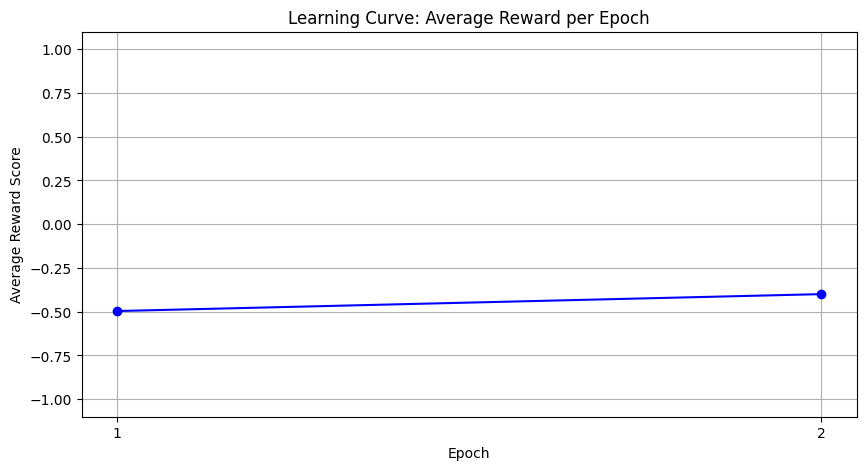


시각화 완료. 그래프는 에포크가 진행됨에 따라 에이전트의 전반적인 성능이 어떻게 변하는지를 보여줍니다.
그래프가 우상향한다면, 에이전트가 성공적으로 학습하고 있다는 의미입니다.


In [15]:
# 7. 학습 곡선(Learning Curve) 시각화 (Epoch 기반)

print("학습 곡선 시각화 중...")

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_avg_rewards, marker='o', linestyle='-', color='b')
plt.title('Learning Curve: Average Reward per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Reward Score')
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1)) # X축 눈금을 정수 에포크 단위로 설정
plt.ylim(-1.1, 1.1)
plt.show()

print("\n시각화 완료. 그래프는 에포크가 진행됨에 따라 에이전트의 전반적인 성능이 어떻게 변하는지를 보여줍니다.")
print("그래프가 우상향한다면, 에이전트가 성공적으로 학습하고 있다는 의미입니다.")


In [16]:
# 8. 최종 성능 평가 (Testing)

print("========== 최종 프롬프트 성능 평가 시작 ==========")

# --- 테스트 루프 실행 ---
test_logs = []
test_rewards = []

# 테스트에서는 'final_trained_prompt'를 고정하여 사용합니다.
# 프롬프트를 업데이트하지 않으므로, 이전에 컴파일한 단순 평가용 앱(eval_app)을 재사용합니다.
final_trained_prompt = log_df['prompt_at_execution'][9]

test_inputs = []
for index, row in test_df.iterrows():
    test_inputs.append({
        "system_prompt": final_trained_prompt,
        "user_query": row['question'],
        "evidence": str(row['evidence']),
        "sql": str(row['SQL'])
    })

# 테스트셋 전체를 배치로 한번에 실행합니다.
test_results = eval_app.batch(test_inputs, config={"max_concurrency": 5})

# --- 결과 분석 및 출력 ---
for idx, result in enumerate(test_results):
    reward = result.get('evaluation_result', {}).get('reward_score', -1.0)
    test_rewards.append(reward)
    
    test_logs.append({
        "index": test_df.index[idx],
        "question": test_inputs[idx]['user_query'],
        "used_prompt": final_trained_prompt,
        "generated_sql": result.get('llm_result', 'N/A'),
        "reward": reward,
        "correctness": result.get('evaluation_result', {}).get('correctness', 'N/A'),
    })

test_log_df = pd.DataFrame(test_logs)
test_log_df.to_csv("test_log_batch.csv", index=False, encoding='utf-8-sig')

avg_reward = np.mean(test_rewards)
success_rate = (np.array(test_rewards) >= 1.0).mean()

print("\n\n========== 최종 프롬프트 성능 평가 종료 ==========")
print(f"테스트 데이터셋 크기: {len(test_df)}개")
print(f"평균 보상 점수: {avg_reward:.3f}")
print(f"성공률 (보상 >= 1.0): {success_rate:.2%}")
print("\n테스트 상세 결과가 'test_log_batch.csv' 파일로 저장되었습니다.")

print("\n\n" + "="*25)
print("     최종 학습된 시스템 프롬프트")
print("="*25)
print(final_trained_prompt)


========== 최종 프롬프트 성능 평가 시작 ==========


========== 최종 프롬프트 성능 평가 종료 ==========
테스트 데이터셋 크기: 47개
평균 보상 점수: -0.851
성공률 (보상 >= 1.0): 0.00%

테스트 상세 결과가 'test_log_batch.csv' 파일로 저장되었습니다.


     최종 학습된 시스템 프롬프트
당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다.



In [17]:
# 8. 최종 성능 평가 (Testing)

print("========== 최종 프롬프트 성능 평가 시작 ==========")

# --- 테스트를 위한 간소화된 그래프 정의 ---
# 테스트 단계에서는 프롬프트를 업데이트하지 않으므로, 'update_prompt' 노드가 없는
# 간단한 'generate -> evaluate' 그래프를 사용합니다.
test_workflow = StateGraph(SimpleGraphState)
test_workflow.add_node("generate_sql", generate_sql)
test_workflow.add_node("evaluate_sql", evaluate_sql)
test_workflow.set_entry_point("generate_sql")
test_workflow.add_edge("generate_sql", "evaluate_sql")
test_workflow.add_edge("evaluate_sql", END)
test_app = test_workflow.compile()

# --- 테스트 루프 실행 ---
test_logs = []
test_rewards = []
final_trained_prompt = log_df['prompt_at_execution'][9]
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="테스트 진행 중"):
    # SystemPrompt = """당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다."""

    # 테스트에서는 'Sys'를 고정하여 사용합니다.
    initial_state = {
        "system_prompt": final_trained_prompt,
        "user_query": row['question'],
        "evidence": str(row['evidence']),
        "sql": str(row['SQL']),
        "retry_count": 0, # 테스트에서는 재시도 없음
    }
    
    try:
        final_state = test_app.invoke(initial_state)
        
        reward = final_state.get('evaluation_result', {}).get('reward_score', -1.0)
        test_rewards.append(reward)
        
        test_logs.append({
            "index": index,
            "question": row['question'],
            "used_prompt": final_trained_prompt,
            "generated_sql": final_state.get('llm_result', 'N/A'),
            "reward": reward,
            "correctness": final_state.get('evaluation_result', {}).get('correctness', 'N/A'),
        })

    except Exception as e:
        print(f"!!!!! 테스트 데이터 {index}에서 오류 발생: {e} !!!!!")
        test_rewards.append(-1.0)
        test_logs.append({
            "index": index, "question": row['question'], "used_prompt": final_trained_prompt,
            "generated_sql": "ERROR", "reward": -1.0, "correctness": "ERROR",
        })
        continue

# --- 결과 분석 및 출력 ---
test_log_df = pd.DataFrame(test_logs)
test_log_df.to_csv("test_log.csv", index=False, encoding='utf-8-sig')

avg_reward = np.mean(test_rewards)
success_rate = (np.array(test_rewards) >= 1.0).mean()

print("\n\n========== 최종 프롬프트 성능 평가 종료 ==========")
print(f"테스트 데이터셋 크기: {len(test_df)}개")
print(f"평균 보상 점수: {avg_reward:.3f}")
print(f"성공률 (보상 >= 1.0): {success_rate:.2%}")
print("\n테스트 상세 결과가 'test_log.csv' 파일로 저장되었습니다.")

print("\n\n" + "="*25)
print("     최종 학습된 시스템 프롬프트")
print("="*25)


========== 최종 프롬프트 성능 평가 시작 ==========


테스트 진행 중:   0%|          | 0/47 [00:00<?, ?it/s]



========== 최종 프롬프트 성능 평가 종료 ==========
테스트 데이터셋 크기: 47개
평균 보상 점수: -0.809
성공률 (보상 >= 1.0): 2.13%

테스트 상세 결과가 'test_log.csv' 파일로 저장되었습니다.


     최종 학습된 시스템 프롬프트


In [11]:
# 성공률10% 

In [ ]:
# 일반 Prompt
# 14.89#

In [ ]:
# 배치사이즈
#8.51%


In [ ]:
#2.03

In [ ]:
#4.26%